# Build the LSLGA parent sample

The purpose of this notebook is to build the parent sample for the NASA Legacy Surveys Galaxy Atlas (NLSGA).  The final output files are:
  * large-galaxies-parent.fits -- large galaxies in the Legacy Surveys footprint
  * large-galaxies-parent-dr6-dr7.fits -- large galaxies in the DR6+DR7 footprint

Our starting catalog is the file hyperleda-d25min10.txt, which contains 2,118,186 objects and is the raw output of querying the [Hyperleda database](http://leda.univ-lyon1.fr/fullsql.html) (on 2018 May 2) for all objects with a D(25) isophotal diameter greater than 10 arcsec using the following SQL query:

```SQL
SELECT
  pgc, objname, objtype, al2000, de2000, type, bar, ring,
  multiple, compactness, t, logd25, logr25, pa, bt, it,
  kt, v, modbest
WHERE
  logd25 > 0.2218487 and (objtype='G' or objtype='g' or objtype='M' or objtype='M2' 
                          or objtype='M3' or objtype='MG' or objtype='MC')
ORDER BY
  al2000
```

**ToDo**

1. Build unWISE and GALEX mosaics.
2. Filter and sort the sample; try to remove junk.
3. Construct a group catalog.
4. Include additional metadata in the webpage.

#### We also tested building a parent sample from a query of the NED database but found a number of spurious angular diameter measurements.  Nevertheless, below are some potentially relevant notes.

Our starting catalog is the file *ned-d25min10.txt*, which contains 8,131,378 objects and is the (semi-raw) output of querying the NED database (on 2018 March 26) for all objects with a D(25) isophotal diameter (in any band) greater than 10 arcsec, with no requirements on redshift or object type.  

Next, we run
```bash
% time python parse-ned-sample
```
to restrict the sample to:
  1. "galaxies" (object type "G", "GGroup", "GPair", "GTrpl", or "PofG"), leaving 4,755,411 objects;
  2. objects with an approximate magnitude and angular diameter (from NED, in any band), leaving 4,392,760 objects;
  3. objects in the Legacy Survey / DESI footprint, leaving 3,878,035 objects.

Specifically, we parse and merge various apparent magnitude estimates (from SDSS/r, 2MASS/Ks, RC3/B, and APM/bJ, in that order of priority), and angular diameters (D25), minor-to-major axis ratios (b/a), and position angles (pa) (from SDSS, 2MASS, RC3, and ESO, in that order of priority).

### Imports and other preliminaries.

In [1]:
import os, sys
import time, warnings
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [60]:
import fitsio
import astropy.table
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont

In [3]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [4]:
sns.set(style='ticks', font_scale=1.5, palette='Set2')
%matplotlib inline

In [5]:
PIXSCALE = 0.262
mindiameter = 1.0     # [arcmin]
maxdiameter = 10.0    # [arcmin]
linking_length = 0.75 # [arcmin]
print('Linking length = {:.2f} arcmin = {:.1f} pixels.'.format(linking_length, linking_length * 60 / PIXSCALE))

Linking length = 0.75 arcmin = 171.8 pixels.


In [6]:
drsuffix = 'dr6-dr7'
LSLGAdir = os.getenv('LSLGA_DIR')
parentfile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-parent.fits')
groupcatfile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-parent-groupcat.fits')
groupsamplefile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-groupcat-{}.fits'.format(drsuffix))
samplefile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-{}.fits'.format(drsuffix))

In [135]:
viewerurl = 'http://legacysurvey.org/viewer'
cutouturl = 'http://legacysurvey.org/viewer-dev/jpeg-cutout'

In [129]:
htmlfile = os.path.join(LSLGAdir, 'index.html')
htmlfile_reject = os.path.join(LSLGAdir, 'index-reject.html')

### Define some convenience QA functions.

In [7]:
def qa_binned_radec(cat, nside=64, png=None):
    import healpy as hp
    import desimodel.io
    import desimodel.footprint
    from desiutil.plots import init_sky, plot_sky_binned
    
    ra, dec = cat['ra'].data, cat['dec'].data
    hpix = desimodel.footprint.radec2pix(nside, ra, dec)
    
    fig, ax = plt.subplots(figsize=(9, 5))

    with warnings.catch_warnings():
        pixweight = desimodel.io.load_pixweight(nside)
        fracarea = pixweight[hpix]
        weight = 1 / fracarea
        
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax);
        plot_sky_binned(ra, dec, weights=weight, 
                        max_bin_area=hp.nside2pixarea(nside, degrees=True),
                        verbose=False, clip_lo='!1', cmap='viridis',
                        plot_type='healpix', basemap=basemap,
                        label=r'$N$(Large Galaxies) / deg$^2$')
        plt.suptitle('Parent Sample')
    
    if png:
        fig.savefig(png)

In [8]:
def qa_mag_d25(cat, supercat):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.hexbin(supercat['mag'], np.log10(supercat['d25']), extent=(0, 25, -1, 3),
              mincnt=1, cmap='viridis')
    ax.scatter(cat['mag'], np.log10(cat['d25']), s=5)
    #ax.hexbin(cat['mag'], np.log10(cat['d25']), extent=(5, 23, -1, 2),
    #          mincnt=1, cmap='viridis')
    ax.axhline(y=np.log10(10 / 60), ls='-', lw=2, color='k', alpha=0.8)
    ax.axhline(y=np.log10(mindiameter), ls='--', lw=2, color='red', alpha=0.8)
    ax.axhline(y=np.log10(maxdiameter), ls='--', lw=2, color='red', alpha=0.8)
    ax.set_xlabel('B mag')
    ax.set_ylabel(r'$\log_{10}\, D_{25}$ (arcmin)')

In [47]:
def qa_radec_dr(parent, sample):
    idr5 = sample['dr'] == 'dr5'
    idr6 = sample['dr'] == 'dr6'
    idr7 = sample['dr'] == 'dr7'

    fig, ax = plt.subplots()
    ax.scatter(parent['ra'], parent['dec'], alpha=0.5, s=5, label='Parent Catalog')
    ax.scatter(sample['ra'][idr5], sample['dec'][idr5], s=10, label='In DR5')
    ax.scatter(sample['ra'][idr6], sample['dec'][idr6], s=10, label='In DR6')
    #ax.scatter(sample['ra'][idr7], sample['dec'][idr7], s=10, label='In DR7')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='upper left', fontsize=10, frameon=True)#, ncol=3)

### Read the Hyperleda super-sample and row-matched AllWISE catalog.

In [10]:
def read_hyperleda():
    """Read the Hyperleda catalog.
    
    """
    hyperledafile = os.path.join(LSLGAdir, 'sample', 'hyperleda-d25min10.fits')
    allwisefile = hyperledafile.replace('.fits', '-allwise.fits')

    leda = astropy.table.Table(fitsio.read(hyperledafile, ext=1))
    print('Read {} objects from {}'.format(len(leda), hyperledafile))

    allwise = astropy.table.Table(fitsio.read(allwisefile, ext=1, lower=True))
    print('Read {} objects from {}'.format(len(allwise), allwisefile))

    # Merge the tables
    allwise.rename_column('ra', 'wise_ra')
    allwise.rename_column('dec', 'wise_dec')
    
    leda = astropy.table.hstack( (leda, allwise) )
    leda['inwise'] = (np.array(['NULL' not in dd for dd in allwise['designation']]) * 
                      np.isfinite(allwise['w1sigm']) * np.isfinite(allwise['w2sigm']) )
    
    print('Found {} / {} objects with WISE photometry.'.format(np.sum(leda['inwise']), len(leda)))
    
    return leda

In [11]:
leda = read_hyperleda()
leda

Read 2118186 objects from /Users/ioannis/research/projects/LSLGA/sample/hyperleda-d25min10.fits
Read 2118186 objects from /Users/ioannis/research/projects/LSLGA/sample/hyperleda-d25min10-allwise.fits
Found 1554791 / 2118186 objects with WISE photometry.


galaxy,pgc,objtype,ra,dec,type,bar,ring,multiple,compactness,t,d25,r25,pa,bt,it,kt,modbest,z,mag,designation,wise_ra,wise_dec,cntr,w1mpro,w1sigmpro,w2mpro,w2sigmpro,w3mpro,w3sigmpro,w4mpro,w4sigmpro,nb,na,cc_flags,ext_flg,ph_qual,w1mag,w1sigm,w2mag,w2sigm,w3mag,w3sigm,w4mag,w4sigm,tmass_key,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass,inwise
bytes28,int64,bytes2,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,bytes20,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,bool
PGC2456621,2456621,g,0.000279,53.9904932,nan,nan,nan,nan,nan,nan,0.57544,0.295121,48.0,17.24,nan,14.635,nan,nan,17.24,NULL,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
PGC639648,639648,G,0.0003765,-36.1988588,nan,nan,nan,nan,nan,nan,0.213796,0.112202,100.0,18.58,nan,nan,nan,nan,18.58,J000000.04-361155.2,0.0001762,-36.1986875,36401351031683,15.624,0.039,15.286,0.074,11.441,0.138,8.682,nan,1,0,0000,0,AABU,15.33,0.031,15.044,0.079,11.375,0.14,8.626,0.359,0,nan,nan,nan,nan,nan,nan,True
PGC622563,622563,G,0.000474,-37.4760687,nan,nan,nan,nan,nan,nan,0.295121,0.131826,128.0,17.75,15.835,13.442,nan,nan,17.75,J000000.11-372834.6,0.0004772,-37.4762838,37901351043221,13.59,0.025,13.489,0.03,12.717,0.436,9.121,nan,1,0,0000,1,AACU,13.333,0.011,13.24,0.022,12.184,0.427,8.64,nan,555089782,15.626,0.101,14.775,0.096,14.377,0.093,True
PGC1191650,1191650,g,0.000507,1.3324473,nan,nan,nan,nan,nan,nan,0.229087,0.123027,84.0,19.05,nan,nan,nan,nan,19.05,NULL,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
PGC1982072,1982072,G,0.000603,32.1365967,nan,nan,nan,nan,nan,nan,0.323594,0.134896,136.5,17.78,nan,13.728,nan,nan,17.78,J000000.08+320811.7,0.0003588,32.1366072,131801351041012,13.953,0.027,13.699,0.034,9.883,0.047,7.525,0.126,1,0,d000,1,AAAB,13.711,0.016,13.506,0.03,9.725,0.046,7.504,0.18,338226820,15.945,0.096,15.256,0.127,14.795,0.135,True
PGC535833,535833,G,0.00066,-44.577893,nan,nan,nan,nan,nan,nan,0.334965,0.171791,148.5,17.63,17.135,nan,nan,nan,17.63,J000000.15-443440.8,0.0006345,-44.5780196,44001351005367,15.497,0.041,15.269,0.083,12.006,0.318,8.353,nan,1,0,0000,0,AABU,15.224,0.044,15.093,0.139,11.777,0.286,8.074,nan,0,nan,nan,nan,nan,nan,nan,True
SDSSJ000000.16-001108.5,4165833,G,0.000702,-0.1857632,nan,nan,nan,nan,nan,nan,0.180717,0.110154,nan,18.873,17.503,nan,39.84,0.195054601532,18.873,J000000.16-001108.6,0.0007006,-0.18574,100001351018364,14.58,0.032,13.951,0.042,10.355,0.075,8.014,0.252,1,0,0000,0,AAAB,14.52,0.056,13.896,0.052,10.357,0.11,7.693,nan,0,nan,nan,nan,nan,nan,nan,True
PGC520795,520795,G,0.0007365,-45.9540486,nan,nan,nan,nan,nan,nan,0.338844,0.149624,24.68,17.54,15.5,13.341,nan,nan,17.54,J000000.14-455715.2,0.0005894,-45.9542465,45501351005362,13.482,0.024,13.31,0.03,12.317,0.43,8.655,nan,1,0,0000,1,AACU,13.226,0.011,13.066,0.032,12.014,0.364,8.294,nan,572925716,15.409,0.086,14.683,0.09,14.122,0.086,True
PGC1961515,1961515,G,0.000762,31.7311001,nan,nan,nan,nan,nan,nan,0.39355,0.164059,160.33,17.38,nan,13.47,nan,nan,17.38,J000000.15+314351.3,0.0006609,31.7309335,131801351028798,14.018,0.039,13.906,0.049,10.515,0.098,8.475,0.503,2,1,0000,4,AAAC,13.346,0.015,13.268,0.029,9.894,0.058,8.404,0.424,338227585,15.632,0.089,15.001,0.112,14.616,0.129,True


#### WISE QA

In [12]:
def qa_wise():
    inw1 = leda['inwise']
    now1 = ~inw1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.scatter(leda['ra'], leda['dec'], s=1)
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Dec')
    
    ax2.scatter(leda['mag'][inw1], leda['w1mag'][inw1] - leda['w2mag'][inw1], s=1)
    ax2.set_xlim(5, 25)
    ax2.set_ylim(-3, 3)        
    ax2.set_xlabel('B')
    ax2.set_ylabel('W1 - W2')

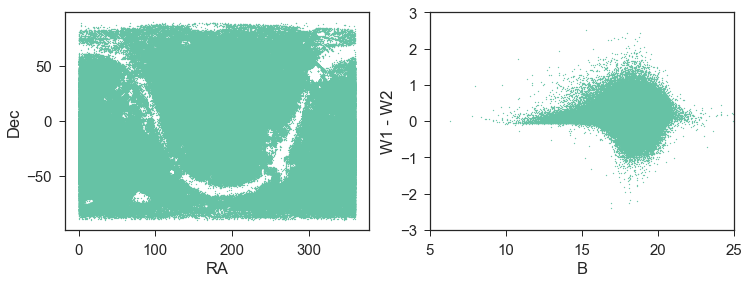

In [13]:
qa_wise()

### Define the parent sample as the subset of objects in the LS/DESI footprint.

We also apply minimum and maximum angular diameter cuts here.

In [14]:
def build_parent(cat, nside=128):
    """Identify the galaxies in the nominal LS/DESI footprint."""
    import desimodel.io
    import desimodel.footprint
    
    tiles = desimodel.io.load_tiles(onlydesi=True)
    indesi = desimodel.footprint.is_point_in_desi(tiles, ma.getdata(cat['ra']), 
                                                  ma.getdata(cat['dec']))
    keep = np.where( indesi * np.isfinite(cat['mag']) * # about 13,000 objects have no magnitude...
                    (cat['d25'] >= mindiameter) * 
                    (cat['d25'] <= maxdiameter) * 1 )[0]
    
    parent = cat[keep]
    ngal = len(parent)
    
    print('Keeping {} / {} objects in the DESI footprint with {:.3f} < D(25) < {:.3f} arcmin.'.format(
        ngal, len(cat), mindiameter, maxdiameter))
    #print('Writing {}'.format(parentfile))
    #parent.write(parentfile, overwrite=True)    
    
    return parent

In [15]:
#ww = ['NGC0292' in gg for gg in leda['galaxy']]
#ww = ['MG' in tt for tt in leda['objtype']]

In [16]:
%time parent = build_parent(leda)

Keeping 9805 / 2118186 objects in the DESI footprint with 1.000 < D(25) < 10.000 arcmin.
CPU times: user 6.37 s, sys: 163 ms, total: 6.54 s
Wall time: 5.88 s


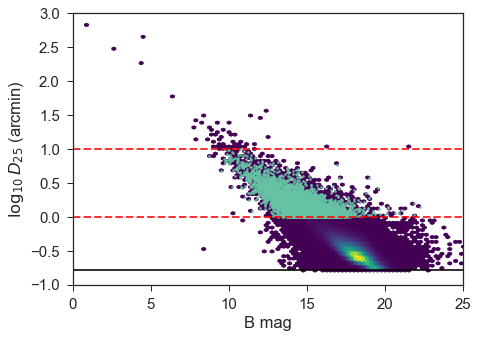

In [17]:
qa_mag_d25(parent, leda)

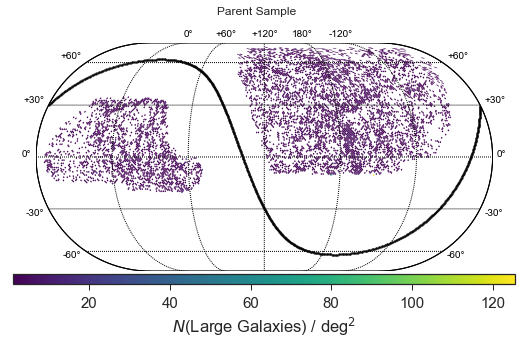

In [18]:
qa_binned_radec(parent)

### Construct a group catalog using a friends-of-friends algorithm.

In [19]:
def _diff_angle(ra1, dec1, ra2, dec2):
    """Compute the angular distance between points on the sky."""
    theta1 = np.radians(dec1) + np.pi / 2
    theta2 = np.radians(dec2) + np.pi / 2
    cosgamma = ( np.sin(theta1) * np.sin(theta2) * 
                 np.cos( np.radians(ra1 - ra2) ) +
                 np.cos(theta1) * np.cos(theta2) )
    
    #import pdb ; pdb.set_trace()
    
    cosgamma[cosgamma > 1] = 1.0
    diff = np.degrees(np.arccos(cosgamma)) * 60 # [arcmin]
    
    return diff.data

In [20]:
def fof_groups(cat, link=2, verbose=True):
    """Find groups using a friends-of-friends algorithm.
    
    """
    from pydl.pydlutils.spheregroup import spheregroup

    grp, mult, frst, nxt = spheregroup(cat['ra'], cat['dec'], link / 60.0)
    ngrp = max(grp) + 1

    if verbose:
        npergrp, _ = np.histogram(grp, bins=len(grp), range=(0, len(grp)))
        print('Found {} total groups, including:'.format(ngrp))
        print('  {} groups with 1 member'.format(np.sum( (npergrp == 1) ).astype('int')))
        print('  {} groups with 2-5 members'.format(np.sum( (npergrp > 1)*(npergrp <= 5) ).astype('int')))
        print('  {} groups with 5-10 members'.format(np.sum( (npergrp > 5)*(npergrp <= 10) ).astype('int')))
        print('  {} groups with >10 members'.format(np.sum( (npergrp > 10) ).astype('int')))
        
    return (grp, mult, frst, nxt)

In [21]:
%time (grp, mult, frst, nxt) = fof_groups(parent, link=linking_length, verbose=True)

Found 9657 total groups, including:
  9517 groups with 1 member
  140 groups with 2-5 members
  0 groups with 5-10 members
  0 groups with >10 members
CPU times: user 5.53 s, sys: 158 ms, total: 5.69 s
Wall time: 5.68 s


In [28]:
def build_groupcat(cat, grp, mult, frst, nxt):
    """Build the final group catalog."""

    from astropy.table import Column, Table
    from astrometry.util.starutil_numpy import radectoxyz, xyztoradec, arcsec_between

    ngrp = max(grp) + 1    
    groupid = np.arange(ngrp)
    
    groupcat = Table()
    groupcat.add_column(Column(name='groupid', dtype='i4', length=ngrp, data=groupid)) # unique ID number
    #groupcat.add_column(Column(name='galaxy', dtype='S1000', length=ngrp))
    groupcat.add_column(Column(name='nmembers', dtype='i4', length=ngrp))
    groupcat.add_column(Column(name='ra', dtype='f8', length=ngrp))  # average RA
    groupcat.add_column(Column(name='dec', dtype='f8', length=ngrp)) # average Dec
    groupcat.add_column(Column(name='width', dtype='f4', length=ngrp)) # maximum separation
    groupcat.add_column(Column(name='d25max', dtype='f4', length=ngrp))
    groupcat.add_column(Column(name='d25min', dtype='f4', length=ngrp))
    groupcat.add_column(Column(name='fracmasked', dtype='f4', length=ngrp))
    
    # Add the groupid to the parent catalog.
    outcat = cat.copy()
    outcat.add_column(Column(name='groupid', dtype='i4', length=len(cat)))
    
    #t0 = time.time()
    npergrp, _ = np.histogram(grp, bins=len(grp), range=(0, len(grp)))
    #print('Time to build the histogram = {:.3f} minutes.'.format( (time.time() - t0) / 60 ) )    
    
    big = np.where( npergrp > 1 )[0]
    small = np.where( npergrp == 1 )[0]

    if len(small) > 0:
        groupcat['nmembers'][small] = 1
        groupcat['groupid'][small] = groupid[small]
        groupcat['ra'][small] = cat['ra'][grp[small]]
        groupcat['dec'][small] = cat['dec'][grp[small]]
        groupcat['d25max'][small] = cat['d25'][grp[small]]
        groupcat['d25min'][small] = cat['d25'][grp[small]]
        groupcat['width'][small] = cat['d25'][grp[small]]
        
        outcat['groupid'][grp[small]] = groupid[small]

    for igrp in range(len(big)):
        jj = frst[big[igrp]]
        ig = list()
        ig.append(jj)
        while (nxt[jj] != -1):
            ig.append(nxt[jj])
            jj = nxt[jj]
        ig = np.array(ig)
        
        ra1, dec1 = cat['ra'][ig].data, cat['dec'][ig].data        
        ra2, dec2 = xyztoradec(np.mean(radectoxyz(ra1, dec1), axis=0))

        groupcat['ra'][big[igrp]] = ra2
        groupcat['dec'][big[igrp]] = dec2
        
        d25min, d25max = np.min(cat['d25'][ig]), np.max(cat['d25'][ig])

        groupcat['d25max'][big[igrp]] = d25max
        groupcat['d25min'][big[igrp]] = d25min
        
        groupcat['nmembers'][big[igrp]] = len(ig)
        outcat['groupid'][ig] = groupcat['groupid'][big[igrp]]
        
        # Get the distance of each object from every other object.
        #diff = arcsec_between(ra1, dec1, ra2, dec2) / 60 # [arcmin] # group center
        
        diff = list()
        for _ra, _dec in zip(ra1, dec1):
            diff.append(arcsec_between(ra1, dec1, _ra, _dec) / 60) # [arcmin]
        
        #if len(ig) > 2:
        #    import pdb ; pdb.set_trace()
        diameter = np.hstack(diff).max()
        groupcat['width'][big[igrp]] = diameter
            
    print('Writing {}'.format(groupcatfile))
    groupcat.write(groupcatfile, overwrite=True)    
        
    return groupcat, outcat

In [29]:
%time groupcat, parentcat = build_groupcat(parent, grp, mult, frst, nxt)
groupcat

Writing /Users/ioannis/research/projects/LSLGA/sample/large-galaxies-parent-groupcat.fits
CPU times: user 138 ms, sys: 6.89 ms, total: 145 ms
Wall time: 160 ms


groupid,nmembers,ra,dec,width,d25max,d25min,fracmasked
int32,int32,float64,float64,float32,float32,float32,float32
0,1,0.029208,8.2791111,1.54882,1.54882,1.54882,0.0
1,1,0.0359505,-6.3739239,1.42561,1.42561,1.42561,0.0
2,1,0.089541,-2.6120278,1.43549,1.43549,1.43549,0.0
3,1,0.118755,17.2202687,1.14815,1.14815,1.14815,0.0
4,1,0.1580835,28.3844722,1.15611,1.15611,1.15611,0.0
5,1,0.2332605,20.3381529,1.78238,1.78238,1.78238,0.0
6,1,0.2454585,28.9116944,1.25603,1.25603,1.25603,0.0
7,1,0.2515185,6.2419546,1.18304,1.18304,1.18304,0.0
8,1,0.2843925,6.3372134,1.07399,1.07399,1.07399,0.0


#### Write out the parent catalog now that it contains the group id.

In [30]:
print('Writing {}'.format(parentfile))
parentcat.write(parentfile, overwrite=True)

Writing /Users/ioannis/research/projects/LSLGA/sample/large-galaxies-parent.fits


### Identify the set of groups in the DR6/DR7 footprint.

In [105]:
def group_diameter(onegroup):
    """Define the diameter or angular extent of the group."""
    return 1.2 * np.max( (3 * onegroup['width'], 3 * onegroup['d25max']) ) # [arcmin]

In [33]:
def init_survey(dr='dr7'):
    """
    rsync -auvzP cori:"/global/project/projectdirs/cosmo/work/legacysurvey/dr5/survey-ccds-dr5-patched.kd.fits" $LSLGA_DIR/sample/dr5/
    rsync -auvzP cori:"/global/cscratch1/sd/dstn/dr6plus/survey-ccds-dr6plus.kd.fits" $LSLGA_DIR/sample/dr6/
    rsync -auvzP cori:"/global/cscratch1/sd/desiproc/dr7/survey-ccds-dr7.kd.fits" $LSLGA_DIR/sample/dr7/

    """
    from legacypipe.survey import LegacySurveyData

    try:
        del survey
    except:
        pass
    
    survey = LegacySurveyData(survey_dir=os.path.join(LSLGAdir, 'sample', dr.lower()),
                                                      output_dir=LSLGAdir)

    return survey

In [34]:
def simple_wcs(onegroup, diam):
    """Build a simple WCS object for a single group.
    
    """
    from astrometry.util.util import Tan
    
    size = np.rint(diam * 60 / PIXSCALE).astype('int') # [pixels]
    wcs = Tan(onegroup['ra'], onegroup['dec'], size/2+0.5, size/2+0.5,
                 -PIXSCALE/3600.0, 0.0, 0.0, PIXSCALE/3600.0, 
                 float(size), float(size))
    return wcs

In [35]:
def _build_sample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_sample_one(*args)

In [36]:
def build_sample_one(onegroup, verbose=False):
    """Wrapper function to find overlapping grz CCDs for a given group.
    
    """
    diam = group_diameter(onegroup) # [arcmin]
    
    wcs = simple_wcs(onegroup, diam)
    try:
        dr = 'dr5'
        #dr = 'dr7'
        #print('Looking for {} in {}...'.format(obj['galaxy'], dr.upper()))
        survey = init_survey(dr=dr)
        ccds = survey.ccds_touching_wcs(wcs)
    except:
        #print('Looking for {} in DR6...'.format(obj['galaxy']))
        try:
            dr = 'dr6'
            survey = init_survey(dr=dr)
            ccds = survey.ccds_touching_wcs(wcs)
        except:
            return [None, None]
    
    if ccds:
        # Is there 3-band coverage?
        if 'g' in ccds.filter and 'r' in ccds.filter and 'z' in ccds.filter:
            if verbose:
                print('Group {:08d}: {} CCDs, RA = {:.5f}, Dec = {:.5f}, Diameter={:.4f} arcmin'.format(
                        onegroup['groupid'], len(ccds), onegroup['ra'], onegroup['dec'], diam))
                sys.stdout.flush()
            return [dr, onegroup]
    
    return [None, None]

In [37]:
def build_sample(groupcat, use_nproc=nproc):
    """Build the full sample with grz coverage in DR6."""

    sampleargs = list()
    for gg in groupcat:
        sampleargs.append( (gg, True) ) # the False refers to verbose=False

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_sample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_sample_one(args))
            
    # Remove non-matching objects and write out the sample
    rr = list(zip(*result))    
    outgroupcat = astropy.table.vstack(list(filter(None, rr[1])))
    outgroupcat['dr'] = list(filter(None, rr[0]))
    print('Found {}/{} objects in the DR6/DR7 footprint.'.format(len(outgroupcat), len(groupcat)))
    
    return outgroupcat

In [39]:
#groupsample = build_sample_one(groupcat[1408])

In [40]:
#%time groupsample = build_sample(groupcat[:500])

In [38]:
samplelogfile = os.path.join(LSLGAdir, 'sample', 'build-sample-{}.log'.format(drsuffix))
print('Building the sample.')
print('Logging to {}'.format(samplelogfile))
t0 = time.time()
with open(samplelogfile, 'w') as log:
    with redirect_stdout(log):
        groupsample = build_sample(groupcat)
print('Found {}/{} groups in the LS footprint.'.format(len(groupsample), len(groupcat)))
print('Total time = {:.3f} minutes.'.format( (time.time() - t0) / 60 ) )

Building the sample.
Logging to /Users/ioannis/research/projects/LSLGA/sample/build-sample-dr6-dr7.log
Found 7044/9657 groups in the LS footprint.
Total time = 1.104 minutes.


#### Cross-reference the group catalog to the parent sample and then write out.

In [41]:
sample = parentcat[np.where( np.in1d( parentcat['groupid'], groupsample['groupid']) )[0]]
print('Writing {}'.format(samplefile))
sample.write(samplefile, overwrite=True)

print('Writing {}'.format(groupsamplefile))
groupsample.write(groupsamplefile, overwrite=True)

Writing /Users/ioannis/research/projects/LSLGA/sample/large-galaxies-dr6-dr7.fits
Writing /Users/ioannis/research/projects/LSLGA/sample/large-galaxies-groupcat-dr6-dr7.fits


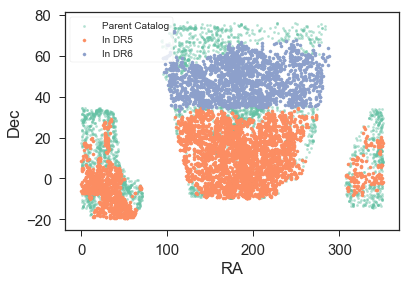

In [48]:
qa_radec_dr(groupcat, groupsample)

### Get viewer cutouts of every group.

In [50]:
jpgdir = os.path.join(LSLGAdir, 'cutouts', 'jpg')
if not os.path.isdir(jpgdir):
    os.mkdir(jpgdir)

In [51]:
def get_groupname(group):
    return 'group{:08d}-n{:03d}'.format(group['groupid'], group['nmembers'])

In [52]:
def get_layer(group):
    if group['dr'] == 'dr6':
        layer = 'mzls+bass-dr6'
    elif group['dr'] == 'dr5':
        layer = 'decals-dr5'
    elif group['dr'] == 'dr7':
        layer = 'decals-dr5'
    return layer

In [53]:
def _get_cutouts_one(args):
    """Wrapper function for the multiprocessing."""
    return get_cutouts_one(*args)

In [77]:
def get_cutouts_one(group, clobber=False):
    """Get viewer cutouts for a single galaxy."""

    layer = get_layer(group)
    groupname = get_groupname(group)
        
    diam = group_diameter(group) # [arcmin]
    size = np.ceil(diam * 60 / PIXSCALE).astype('int') # [pixels]

    imageurl = '{}/?ra={:.8f}&dec={:.8f}&pixscale={:.3f}&size={:g}&layer={}'.format(
        cutouturl, group['ra'], group['dec'], PIXSCALE, size, layer)
        
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(groupname))
    cmd = 'wget --continue -O {:s} "{:s}"' .format(jpgfile, imageurl)
    if os.path.isfile(jpgfile) and not clobber:
        print('File {} exists...skipping.'.format(jpgfile))
    else:
        if os.path.isfile(jpgfile):
            os.remove(jpgfile)
        print(cmd)
        os.system(cmd)
    sys.stdout.flush()
            
    # Get the fraction of masked pixels
    im = np.asarray( Image.open(jpgfile) )
    area = np.product(im.shape[:2])
    fracmasked = ( np.sum(im[:, :, 0] == 32) / area, 
                   np.sum(im[:, :, 1] == 32) / area,
                   np.sum(im[:, :, 2] == 32) / area )
    
    return np.max(fracmasked)

In [78]:
def get_cutouts(groupsample, use_nproc=nproc, clobber=False):
    """Get viewer cutouts of the whole sample."""

    cutoutargs = list()
    for gg in groupsample:
        cutoutargs.append( (gg, clobber) )

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_get_cutouts_one, cutoutargs)
        p.close()
    else:
        result = list()
        for args in cutoutargs:
            result.append(_get_cutouts_one(args))

    fracmasked = np.hstack(result)
    return fracmasked

In [108]:
nmin = 1
indx = groupsample['nmembers'] > nmin
print('Getting cutouts of {} groups with >{} member(s).'.format(np.sum(indx), nmin))
#groupsample['fracmasked'][indx] = get_cutouts(groupsample[indx], clobber=True)#, use_nproc=1)

Getting cutouts of 115 groups with >1 member(s).


In [109]:
#get_cutouts_one(groupsample[0], clobber=False)

In [110]:
cutlogfile = os.path.join(LSLGAdir, 'cutouts', 'get-cutouts-{}.log'.format(drsuffix))
print('Getting viewer cutouts.')
print('Logging to {}'.format(cutlogfile))
t0 = time.time()
with open(cutlogfile, 'w') as log:
    with redirect_stdout(log):
        get_cutouts(groupsample[indx], clobber=True)
print('Total time = {:.3f} minutes.'.format( (time.time() - t0) / 60 ))

Getting viewer cutouts.
Logging to /Users/ioannis/research/projects/LSLGA/cutouts/get-cutouts-dr6-dr7.log
Total time = 4.258 minutes.


#### Overwrite the group sample catalog with fracmasked.

In [83]:
print('Writing {}'.format(groupsamplefile))
groupsample.write(groupsamplefile, overwrite=True)

Writing /Users/ioannis/research/projects/LSLGA/sample/large-galaxies-groupcat-dr6-dr7.fits


#### Add labels and a scale bar.

In [114]:
barlen = np.round(60.0 / PIXSCALE).astype('int') # [1 arcmin in pixels]
fonttype = os.path.join(LSLGAdir, 'cutouts', 'Georgia.ttf')

In [163]:
def get_galaxy(group, sample, html=False):
    """List the galaxy name.
    
    """
    these = group['groupid'] == sample['groupid']
    galaxy = [gg.decode('utf-8').strip().lower() for gg in sample['galaxy'][these].data]
    
    if html:
        galaxy = ' '.join(np.sort(galaxy)).upper()
    else:
        galaxy = ' '.join(np.sort(galaxy))

    return galaxy

In [116]:
def _add_labels_one(args):
    """Wrapper function for the multiprocessing."""
    return add_labels_one(*args)

In [122]:
def add_labels_one(group, sample, clobber=False, nothumb=False):

    jpgdir = os.path.join(LSLGAdir, 'cutouts', 'jpg')
    pngdir = os.path.join(LSLGAdir, 'cutouts', 'png')
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    groupname = get_groupname(group)
    galaxy = get_galaxy(group, sample, html=True)

    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(groupname))
    pngfile = os.path.join(pngdir, '{}.png'.format(groupname))
    thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(groupname))
    
    if os.path.isfile(jpgfile):
        if os.path.isfile(pngfile) and not clobber:
            print('File {} exists...skipping.'.format(pngfile))
        else:
            im = Image.open(jpgfile)
            sz = im.size
            fntsize = np.round(sz[0]/28).astype('int')
            width = np.round(sz[0]/175).astype('int')
            font = ImageFont.truetype(fonttype, size=fntsize)
            draw = ImageDraw.Draw(im)

            # Label the group--
            draw.text((0+fntsize*2, 0+fntsize*2), galaxy, font=font)
    
            # Add a scale bar--
            x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
            draw.line((x0, yy, x1, yy), fill='white', width=width)
            im.save(pngfile)    
        
            # Generate a thumbnail
            if not nothumb:
                cmd = 'convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
                os.system(cmd)

In [124]:
def add_labels(groupsample, sample, clobber=False):
    labelargs = list()
    for group in groupsample:
        labelargs.append((group, sample, clobber))
    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        res = p.map(_add_labels_one, labelargs)
        p.close()
    else:
        for args in labelargs:
            res = _add_labels_one(args)

In [128]:
%time add_labels(groupsample, sample, clobber=True)

CPU times: user 210 ms, sys: 126 ms, total: 336 ms
Wall time: 42.8 s


In [123]:
#add_labels_one(groupsample[10], sample, clobber=True)

### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do

```bash
 rsync -auvP $LLLSLSLSLLSLLSLGLSLGLSLGALSLGALSLGAA/cutouts/png /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
 rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
```
or
```bash
 rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/png /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
 rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
```
and then the website can be viewed here:
  http://portal.nersc.gov/project/cosmo/temp/ioannis/LSLGA    

In [170]:
reject = []
toss = np.zeros(len(groupsample), dtype=bool)
for ii, gg in enumerate(groupsample['groupid']):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in gg.lower()
        if toss[ii]:
            break
print('Rejecting {} groups.'.format(np.sum(toss)))
groupkeep = groupsample[~toss]
if np.sum(toss) > 0:
    grouprej = groupsample[toss]
else:
    grouprej = []

Rejecting 0 groups.


In [168]:
def html_rows(_groupkeep, sample, nperrow=4):
    
    # Not all objects may have been analyzed.
    these = [os.path.isfile(os.path.join(LSLGAdir, 'cutouts', 'png', '{}.png'.format(
        get_groupname(gg)))) for gg in _groupkeep]
    groupkeep = _groupkeep[these]
    
    nrow = np.ceil(len(groupkeep) / nperrow).astype('int')
    groupsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(groupkeep):
            i2 = len(groupkeep)
        groupsplit.append(groupkeep[i1:i2])
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

    html.write('<table class="ls-gallery">\n')
    html.write('<tbody>\n')
    for grouprow in groupsplit:
        html.write('<tr>\n')
        for group in grouprow:
            groupname = get_groupname(group)
            galaxy = get_galaxy(group, sample, html=True)

            pngfile = os.path.join('cutouts', 'png', '{}.png'.format(groupname))
            thumbfile = os.path.join('cutouts', 'png', 'thumb-{}.png'.format(groupname))
            img = 'src="{}" alt="{}"'.format(thumbfile, galaxy)
            #img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, nicename)
            html.write('<td><a href="{}"><img {}></a></td>\n'.format(pngfile, img))
        html.write('</tr>\n')
        html.write('<tr>\n')
        for group in grouprow:
            groupname = get_groupname(group)
            galaxy = '{}: {}'.format(groupname.upper(), get_galaxy(group, sample, html=True))
            layer = get_layer(group)
            href = '{}/?layer={}&ra={:.8f}&dec={:.8f}&zoom=12'.format(viewerurl, layer, group['ra'], group['dec'])
            html.write('<td><a href="{}" target="_blank">{}</a></td>\n'.format(href, galaxy))
        html.write('</tr>\n')
    html.write('</tbody>\n')            
    html.write('</table>\n')

In [169]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('table.ls-gallery {width: 90%;}\n')
    #html.write('img.ls-gallery {display: block;}\n')
    #html.write('td.ls-gallery {width: 100%; height: auto}\n')
    #html.write('td.ls-gallery {width: 100%; word-wrap: break-word;}\n')
    html.write('p.ls-gallery {width: 80%;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>Legacy Surveys Large Galaxy Atlas</h1>\n')
    html.write("""<p class="ls-gallery">Each thumbnail links to a larger image while the galaxy 
    name below each thumbnail links to the <a href="http://legacysurvey.org/viewer">Sky Viewer</a>.  
    For reference, the horizontal white bar in the lower-right corner of each image represents 
    one arcminute.</p>\n""")
    #html.write('<h2>Large Galaxy Sample</h2>\n')
    html_rows(groupkeep, sample)
    html.write('</body></html>\n')

Splitting the sample into 29 rows with 4 mosaics per row.


In [ ]:
if len(grouprej) > 0:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><head>\n')
        html.write('<style type="text/css">\n')
        html.write('img.ls-gallery {display: block;}\n')
        html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
        html.write('</style>\n')
        html.write('</head><body>\n')
        html.write('<h1>Large Galaxies - Rejected</h1>\n')
        html_rows(grouprej, sample)
        html.write('</body></html>\n')

In [ ]:
stop

In [ ]:
#ww = np.where(['NGC' in gg for gg in parent['galaxy']])[0]
#[print(gg.decode('utf-8'), rr, dd) for (gg, rr, dd) in zip(parent['galaxy'][ww].data, parent['ra'][ww].data, parent['dec'][ww].data)]
#print(ww[4])
#parent[ww]